# Transfer Learning and Mobilenet Model



### 1. Loading and exploring the Dataset

**[1.1]**
Import libraries

In [2]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader

**[1.2]** Building Path DataFrame from Text Files

In [7]:
import pandas as pd
df_label=pd.read_csv("/kaggle/input/roi-signatures/recurrence.csv")

/tmp/ipykernel_36/3943704048.py:2: DtypeWarning: Columns (5,9,33,34,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_label=pd.read_csv("/kaggle/input/roi-signatures/recurrence.csv")


In [8]:
df_label['SOPInstanceUID'].nunique()

285093

censor	Follow-up status at last exam

0	recurrence

1	no recurrence

In [9]:
df_label['Recurrence'].value_counts()

Recurrence
no     219510
yes     65583
Name: count, dtype: int64

In [10]:
import os
import pandas as pd

def gather_image_paths(root_folder):
    image_paths = []
    
    # Walk through the directory
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            # Check if the file is an image (you can add more extensions as needed)
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif','.dcm','.tiff')):
                # Create the full path to the image
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
                
    return image_paths

In [11]:
root_folder = '/kaggle/input/roi-signatures/ROI'
image_paths = gather_image_paths(root_folder)

# Create a DataFrame
df_images = pd.DataFrame(image_paths, columns=['image_path'])

In [12]:
df_images

,image_path
0,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
1,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
2,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
3,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
4,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
...,...
6865,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
6866,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
6867,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...
6868,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...


In [13]:
pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224707 sha256=f4ae178197b9c7d1a449706d7259a7deae703944f0a4161570934bda2fec6f93
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
Note: you may need to restart the kernel to use updated packages.


In [14]:
df_images['image_path'][0]

'/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_3.tiff'

In [15]:
# Create SOPInstanceUID column
df_images['SOPInstanceUID'] = df_images['image_path'].str.split('/').str[-1]  # Extract the final part
df_images['SOPInstanceUID'] = df_images['SOPInstanceUID'].str.replace(r'(_.*|\.tiff)', '', regex=True)  # Remove .tiff and anything behind "_"

In [16]:
df_images['SOPInstanceUID'].iloc[0]

'1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020'

In [17]:
df_images['SOPInstanceUID'].nunique()

144

In [18]:
df_label[['image_path','SOPInstanceUID','Recurrence']]

,image_path,SOPInstanceUID,Recurrence
0,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.219692995923...,yes
1,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.270669885731...,yes
2,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.663784620001...,yes
3,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.403459064768...,yes
4,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.139591549847...,yes
...,...,...,...
285088,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.194763570324...,yes
285089,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.148743410484...,yes
285090,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.185710702347...,yes
285091,/kaggle/input/nsclc-radiogenomics-6-1-21-versi...,1.3.6.1.4.1.14519.5.2.1.4334.1501.275325860156...,yes


In [19]:
df_images

,image_path,SOPInstanceUID
0,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470...
1,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481...
2,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678...
3,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052...
4,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020...
...,...,...
6865,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043...
6866,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213...
6867,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315...
6868,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243...


In [20]:
df_label['SOPInstanceUID'].nunique()

285093

In [21]:
# Check if all values in df_images['SOPInstanceUID'] are present in df_label['SOPInstanceUID']
all_present = df_images['SOPInstanceUID'].isin(df_label['SOPInstanceUID']).all()

if all_present:
    print("All values in df_images['SOPInstanceUID'] are present in df_label['SOPInstanceUID'].")
else:
    print("Some values in df_images['SOPInstanceUID'] are not present in df_label['SOPInstanceUID'].")

All values in df_images['SOPInstanceUID'] are present in df_label['SOPInstanceUID'].


In [22]:
# Perform a left join to add the 'Recurrence' column from df_label to df_images using 'SOPInstanceUID' as the key
df = df_images.merge(df_label[['SOPInstanceUID', 'Recurrence']], on='SOPInstanceUID', how='left')

In [23]:
df

,image_path,SOPInstanceUID,Recurrence
0,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470...,yes
1,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481...,yes
2,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678...,no
3,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052...,no
4,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020...,yes
...,...,...,...
6865,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043...,no
6866,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213...,no
6867,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315...,no
6868,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243...,no


In [24]:
df['SOPInstanceUID'].nunique()

144

In [25]:
df['Recurrence'].value_counts()

Recurrence
no     4882
yes    1988
Name: count, dtype: int64

In [26]:
df['Recurrence']=df['Recurrence'].map({'yes':1,'no':0})

In [27]:
df['Recurrence'].value_counts()

Recurrence
0    4882
1    1988
Name: count, dtype: int64

In [28]:
df

,image_path,SOPInstanceUID,Recurrence
0,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470...,1
1,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.209511070481...,1
2,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678...,0
3,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.261114095052...,0
4,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.228980550020...,1
...,...,...,...
6865,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043...,0
6866,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.227104262213...,0
6867,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.651252356315...,0
6868,/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.1...,1.3.6.1.4.1.14519.5.2.1.4334.1501.242040564243...,0


In [29]:
df['image_path'].iloc[0]

'/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.14519.5.2.1.4334.1501.290645545470202264879884114020_3.tiff'

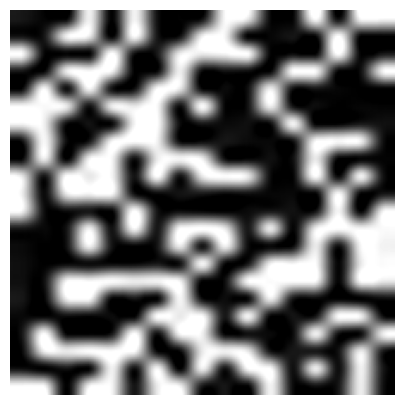

In [30]:
from PIL import Image
import matplotlib.pyplot as plt

image_path=df['image_path'].iloc[10]

# Path to the first image in df['image_path']
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

In [31]:
# Check the image dimensions
image_shape = image.size  # (width, height)

print(f"Image Path: {image_path} - Shape: {image_shape}")

Image Path: /kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_9.tiff - Shape: (224, 224)


In [32]:
# Get image mode
image_mode = image.mode

# Check if it's grayscale or RGB
if image_mode == 'L':
    print(f"The image at {image_path} is Grayscale.")
elif image_mode == 'RGB':
    print(f"The image at {image_path} is RGB.")
else:
    print(f"The image at {image_path} has mode {image_mode}.")


The image at /kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.14519.5.2.1.4334.1501.616661061043176947499161423400_9.tiff is Grayscale.


In [33]:
df_selected=df[['image_path','Recurrence','SOPInstanceUID']]

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Group by SOPInstanceUID
unique_uids = df_selected['SOPInstanceUID'].unique()

# Step 2: Map SOPInstanceUID to Recurrence (one Recurrence per unique SOPInstanceUID)
uid_to_recurrence = df_selected.drop_duplicates(subset=['SOPInstanceUID'])[['SOPInstanceUID', 'Recurrence']]

# Step 3: First split into training and temp sets based on unique SOPInstanceUID
train_uids, temp_uids = train_test_split(
    unique_uids, 
    test_size=0.4,  # 40% of the unique UIDs go to temp
    stratify=uid_to_recurrence['Recurrence'],  # Ensure stratification using the reduced Recurrence labels
    random_state=42  # For reproducibility
)

# Step 4: Second split temp_uids into validation and test sets
val_uids, test_uids = train_test_split(
    temp_uids,
    test_size=0.5,  # Split temp_uids into two equal parts for validation and test
    stratify=uid_to_recurrence[uid_to_recurrence['SOPInstanceUID'].isin(temp_uids)]['Recurrence'],  # Stratify within temp
    random_state=42  # For reproducibility
)

# Step 5: Create the final dataframes by filtering the original dataframe
train_df = df_selected[df_selected['SOPInstanceUID'].isin(train_uids)]
val_df = df_selected[df_selected['SOPInstanceUID'].isin(val_uids)]
test_df = df_selected[df_selected['SOPInstanceUID'].isin(test_uids)]

In [37]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [38]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [39]:
import pandas as pd
from sklearn.utils import resample

# Assuming 'image_path' is a column with paths to images
df = train_df.copy()  # Copy the original DataFrame

# Separate majority and minority classes
df_majority = df[df['Recurrence'] == 0.0]
df_minority = df[df['Recurrence'] == 1.0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=len(df_majority), 
                                 random_state=42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [40]:
train_df = df_upsampled.reset_index(drop=True)

In [41]:
train_df['Recurrence'].value_counts()

Recurrence
0    2951
1    2951
Name: count, dtype: int64

**[1.3]** Apply transformation using compose class to the image. This time we will not only normalize the images but we will also perform some data transformation such as Resize (image_size, image_size).

In [42]:
import torchvision.transforms as transforms

image_size = 224

# Advanced and balanced training transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),  # Reduced rotation degree
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Subtle color changes
    transforms.RandomGrayscale(p=0.05),  # Lower probability of converting to grayscale
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Adds perspective distortion
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Introduces slight translation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Adds slight blur for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization
])

# Transformations for validation and test sets
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize to the target size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

### 2.   Preparing the Dataset

**[2.1]** Filtering and Splitting Image Data

In [43]:
# Define a function to filter images based on DataFrame
def filter_images(df):
    filtered_images = [(row['image_path'], row['Recurrence']) for index, row in df.iterrows()]
    return filtered_images

# Filter images for training and testing sets
train_images = filter_images(train_df)
test_images = filter_images(test_df)
validation_images = filter_images(val_df)

**[2.2]**  Now we will call the DataLoader function that iteratively loads data based on batch size, shuffle and save it into three different variables called `train_loader`, `val_loader` and `test_loader`. Set the `BATCH_SIZE` to 128. The shuffle is a boolean variable. By default the shuffle value is false. If the shuffle is `True` means that the data is randomly shuffled before each epoch, so the order of the data is different in each epoch. (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [44]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2

In [71]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import cv2
from medpy.filter.smoothing import anisotropic_diffusion

class CustomDataset(Dataset):
    def __init__(self, data, transform=None, image_representation="RGB", apply_diffusion=True):
        self.data = data
        self.transform = transform
        self.image_representation = image_representation
        self.apply_diffusion = apply_diffusion

        # Create a dictionary to map class names to integer indices
        self.class_to_index = {label: index for index, label in enumerate(set(label for _, label in data))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        
        try:
            # Open the image
            pil_image = Image.open(image_path)

            # Apply image representation transformations
            if self.image_representation == "RGB":
                pil_image = pil_image.convert('RGB')
            elif self.image_representation in ["GRAY3", "GRAY3_HE", "GRAY3_CLAHE", "GRAY+GRAY_HE+GRAY_CLAHE"]:
                grayscale_image = np.array(pil_image.convert('L'))  # Convert to grayscale
                
                if self.image_representation == "GRAY3":
                    processed_image = np.stack([grayscale_image] * 3, axis=-1)
                elif self.image_representation == "GRAY3_HE":
                    he_image = cv2.equalizeHist(grayscale_image)  # Histogram Equalization
                    processed_image = np.stack([he_image] * 3, axis=-1)
                elif self.image_representation == "GRAY3_CLAHE":
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    clahe_image = clahe.apply(grayscale_image)
                    processed_image = np.stack([clahe_image] * 3, axis=-1)
                elif self.image_representation == "GRAY+GRAY_HE+GRAY_CLAHE":
                    he_image = cv2.equalizeHist(grayscale_image)
                    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
                    clahe_image = clahe.apply(grayscale_image)
                    processed_image = np.stack([grayscale_image, he_image, clahe_image], axis=-1)
                
                # Convert processed NumPy array back to PIL Image
                pil_image = Image.fromarray(processed_image)

            # Convert PIL to NumPy array for processing
            np_image = np.array(pil_image)

            # Apply cleaning techniques
            np_image = self.apply_gaussian_blur(np_image)
            np_image = self.apply_sobel_filter(np_image)

            # Apply anisotropic diffusion (optional)
            if self.apply_diffusion:
                np_image = self.apply_anisotropic_diffusion_filter(np_image)

            # Convert back to PIL image after processing
            pil_image = Image.fromarray((np_image * 255).astype(np.uint8))

            # Resize the image
            pil_image = pil_image.resize((224, 224))

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Create a blank image if there's an error
            pil_image = Image.new('RGB', (224, 224))  # Example size, adjust as needed

        # Apply transformations, if any
        if self.transform:
            pil_image = self.transform(pil_image)

        # Convert label to index
        label_index = self.class_to_index[label]
        label_tensor = torch.tensor(label_index, dtype=torch.long)  # Convert label to tensor

        # Convert PIL image to tensor if using a PyTorch model
        if isinstance(pil_image, Image.Image):
            pil_image = self.pil_to_tensor(pil_image)

        return pil_image, label_tensor

    def apply_anisotropic_diffusion_filter(self, image: np.ndarray) -> np.ndarray:
        """Apply anisotropic diffusion filter to the image."""
        return anisotropic_diffusion(image, niter=5, kappa=50, gamma=0.1)

    def apply_gaussian_blur(self, image: np.ndarray, kernel_size=(5, 5), sigma=1.0) -> np.ndarray:
        """Apply Gaussian blur to the image."""
        return cv2.GaussianBlur(image, kernel_size, sigma)

    def apply_sobel_filter(self, image: np.ndarray) -> np.ndarray:
        """Apply Sobel filter to detect edges in the image."""
        sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        sobel_image = np.sqrt(sobel_x**2 + sobel_y**2)  # Magnitude of the gradients
        sobel_image = np.clip(sobel_image, 0, 255)  # Clip values to valid range
        return sobel_image.astype(np.uint8)

    @staticmethod
    def pil_to_tensor(pil_image):
        """Convert PIL Image to Tensor."""
        return torch.from_numpy(np.array(pil_image)).permute(2, 0, 1).float() / 255.0  # Convert to tensor

In [72]:
train_dataset=CustomDataset(train_images, transform=train_transform,image_representation="GRAY+GRAY_HE+GRAY_CLAHE")
validation_dataset=CustomDataset(validation_images, transform=transform,image_representation="GRAY+GRAY_HE+GRAY_CLAHE")
test_dataset=CustomDataset(test_images, transform=transform,image_representation="GRAY+GRAY_HE+GRAY_CLAHE")

In [73]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 16

# Create DataLoader objects for training, validation, and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) #The num_workers parameter specifies the number of subprocesses, which enables multi-process data loading
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


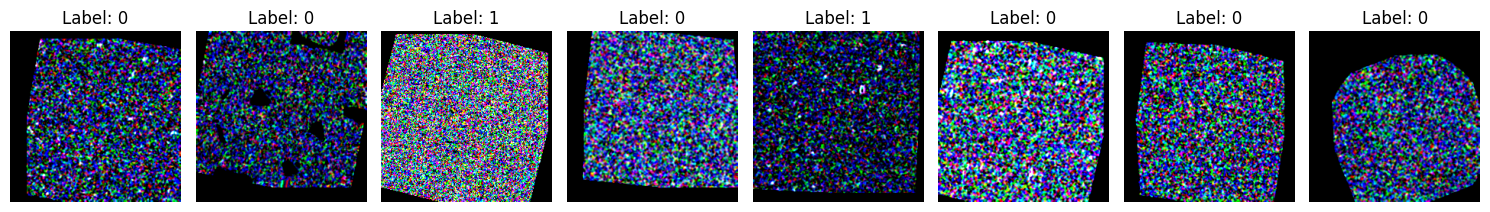

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a tensor image to a numpy array
def tensor_to_numpy(image_tensor):
    return image_tensor.permute(1, 2, 0).numpy()

# Retrieve the first batch of images and labels from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Define number of images to display
num_images = 8

# Plot the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

for i in range(num_images):
    # Convert tensor to numpy array for display
    image_np = tensor_to_numpy(images[i])
    
    # Display the image
    axes[i].imshow(image_np)
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i].item()}')

plt.tight_layout()
plt.show()

In [96]:
train_df['image_path'][0]

'/kaggle/input/roi-signatures/ROI/1.3.6.1.4.1.14519.5.2.1.4334.1501.307275102678463145156203830522_25.tiff'

**[2.3]**  Let's have a look at the length of `train_set`, `val_set`, and `test_set`.

In [75]:
# Print sizes of datasets
print("Training set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

Training set size: 5902
Validation set size: 1357
Test set size: 1396


# 3: Defining the Architecture of MobileNet

**[3.1]** Import `torch.nn` as `nn`, and to import MobilenetV3 architecture we need to import `torchcision.models` as `models`

In [76]:
import torch.nn as nn
import torchvision.models 

In [77]:
from torchvision.models import mobilenet_v3_large

**[3.2]** Now we will initialize the Mobilenet model by specifying the parameter `pretrained = True`, and perform head modification for Classification Task

In [78]:
# Initialize MobileNet with pre-trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load MobileNetV3-Large model
mobilenet_model = mobilenet_v3_large(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 118MB/s] 


**[3.3]** Let's have a look at the MobileNet architecture

##### Task: Print the summary of the Mobile Model

In [53]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


The modified Mobilenet architecture includes three additional fully connected layers after the existing `AdaptiveAvgPool2d` layer. The `AdaptiveAvgPool2d` layer automatically adapts to the input size and performs average pooling, resulting in a fixed-size output regardless of the input size. Therefore, there's no need to explicitly add a `global average pooling layer` when modifying the classification head.


**[3.4]** Let's all layers of the model except the head by setting the value of `requires_grad` as `false`, i.e. no changes happen to its parameters. (https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html#torch.Tensor.requires_grad)

In [79]:
for idx, (name, param) in enumerate(mobilenet_model.named_parameters()):  # Iterate through named parameters of the model
    param.requires_grad = False  # Set requires_grad to False to freeze the parameter
    
# Verify which parameters are frozen
for name, param in mobilenet_model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

features.0.0.weight: requires_grad=False
features.0.1.weight: requires_grad=False
features.0.1.bias: requires_grad=False
features.1.block.0.0.weight: requires_grad=False
features.1.block.0.1.weight: requires_grad=False
features.1.block.0.1.bias: requires_grad=False
features.1.block.1.0.weight: requires_grad=False
features.1.block.1.1.weight: requires_grad=False
features.1.block.1.1.bias: requires_grad=False
features.2.block.0.0.weight: requires_grad=False
features.2.block.0.1.weight: requires_grad=False
features.2.block.0.1.bias: requires_grad=False
features.2.block.1.0.weight: requires_grad=False
features.2.block.1.1.weight: requires_grad=False
features.2.block.1.1.bias: requires_grad=False
features.2.block.2.0.weight: requires_grad=False
features.2.block.2.1.weight: requires_grad=False
features.2.block.2.1.bias: requires_grad=False
features.3.block.0.0.weight: requires_grad=False
features.3.block.0.1.weight: requires_grad=False
features.3.block.0.1.bias: requires_grad=False
features.

In [80]:
# Get unique labels from training, validation, and test datasets
train_labels = [label for _, label in train_images]
validation_labels = [label for _, label in validation_images]
test_labels = [label for _, label in test_images]

# Combine labels from all datasets
all_labels = train_labels + validation_labels + test_labels

# Count the number of unique labels
num_classes = len(set(all_labels))

print("Number of unique classes:", num_classes)

Number of unique classes: 2


**[3.6]** After modifying the last layer of mobilenet, let's modifies the classification head of the MobileNet model by introducing a custom activation function for improved performance in the classification task.
- 3 fully connected layers (the thirst one will be the final layer used for making predictions)

In [81]:
import torch.nn as nn

# Get the number of input features for the classifier
num_features = mobilenet_model.classifier[0].in_features

# Redefine the classifier with a simpler architecture
mobilenet_model.classifier = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),  # Adjusted dropout rate to 0.3 for moderate regularization
    nn.Linear(128, num_classes)  # Directly mapping to the number of classes
)

In [114]:
mobilenet_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

The AdaptiveAvgPool2d layer in the MobileNet architecture effectively performs global average pooling, which is the same function as a global average layer

In [115]:
# Count the number of parameters in mobilenet_model.features
num_params = len(list(mobilenet_model.features.parameters()))

print(f"Total number of indices (parameters) in mobilenet_model.features: {num_params}")

Total number of indices (parameters) in mobilenet_model.features: 170


In [82]:
for idx, param in enumerate(mobilenet_model.features.parameters()):
    if idx <= 60:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [83]:
# Verify which parameters are frozen
for name, param in mobilenet_model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')

features.0.0.weight: requires_grad=True
features.0.1.weight: requires_grad=True
features.0.1.bias: requires_grad=True
features.1.block.0.0.weight: requires_grad=True
features.1.block.0.1.weight: requires_grad=True
features.1.block.0.1.bias: requires_grad=True
features.1.block.1.0.weight: requires_grad=True
features.1.block.1.1.weight: requires_grad=True
features.1.block.1.1.bias: requires_grad=True
features.2.block.0.0.weight: requires_grad=True
features.2.block.0.1.weight: requires_grad=True
features.2.block.0.1.bias: requires_grad=True
features.2.block.1.0.weight: requires_grad=True
features.2.block.1.1.weight: requires_grad=True
features.2.block.1.1.bias: requires_grad=True
features.2.block.2.0.weight: requires_grad=True
features.2.block.2.1.weight: requires_grad=True
features.2.block.2.1.bias: requires_grad=True
features.3.block.0.0.weight: requires_grad=True
features.3.block.0.1.weight: requires_grad=True
features.3.block.0.1.bias: requires_grad=True
features.3.block.1.0.weight: r

### 4. Training and Evaluation of the Model

**[4.1]** Let's create a variable called `device` that will automatically select a GPU if available. Otherwise it will default to CPU.

In [84]:
# # Solution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**[4.2]** Import the relevant class and libraries for `optim`,`ReduceLROnPlateau` and `SummaryWriter`

In [62]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [92]:
%pip install torchsummary

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [87]:
# Solution
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

**[4.3]**  Instantiate a `nn.CrossEntropyLoss()` and save it into a variable called `criterion`. After then Instantiate a `torch.optim.Adam()` optimizer with the model's parameters and 0.0004 as learning rate and save it into a variable called `optimizer`

In [85]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with weight decay
optimizer = optim.Adam(mobilenet_model.parameters(), lr=8e-4, weight_decay=5e-4)

**[4.4]**  Set up a learning rate scheduler `ReduceLROnPlateau` for reducing the learning rate when a metric has stopped improving [ https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html ]

In [88]:
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=1, min_lr=1e-6)

**[4.5]** Define the value of early stopping parameters such as `early_step_counter = 0`, `early_stop_patience = 2`

In [89]:
early_stop_counter = 0
early_stop_patience = 5
best_val_loss = float('inf')

**[4.6]** Lets introduce early stop class call `CustomeCallBack` to check for early stopping if the current validation losses do not improve

In [90]:
from torch.optim.lr_scheduler import ReduceLROnPlateau  # Import ReduceLROnPlateau scheduler from PyTorch

class CustomCallback:
    def __init__(self, early_stop_patience=early_stop_patience, reduce_lr_factor=0.2, reduce_lr_patience=3, reduce_lr_min_lr=0.0000001, checkpoint_path='checkpoint.pth', log_dir='logs'):
        # Initialize callback parameters
        self.early_stop_patience = early_stop_patience  # Patience for early stopping
        self.reduce_lr_factor = reduce_lr_factor  # Factor by which to reduce learning rate
        self.reduce_lr_patience = reduce_lr_patience  # Patience for reducing learning rate
        self.reduce_lr_min_lr = reduce_lr_min_lr  # Minimum learning rate
        self.checkpoint_path = checkpoint_path  # Path to save model checkpoints
        # self.log_dir = log_dir  # Directory for logging

        # Initialize variables for early stopping
        self.early_stop_counter = 0  # Counter for early stopping
        self.best_val_loss = float('inf')  # Best validation loss

        self.optimizer = None  # Optimizer for training
        self.scheduler = None  # Learning rate scheduler

    def set_optimizer(self, optimizer):
        # Set optimizer for training
        self.optimizer = optimizer

    def on_epoch_end(self, epoch, val_loss):
        # Early Stopping
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.early_stop_counter = 0  # Reset counter if validation loss improves
        else:
            self.early_stop_counter += 1  # Increment counter if validation loss does not improve

        if self.early_stop_counter >= self.early_stop_patience:
            print("Early stopping triggered!")
            return True  # Stop training if early stopping criterion is met

        # Reduce LR on Plateau
        if self.scheduler is not None:
            self.scheduler.step(val_loss)  # Adjust learning rate based on validation loss

        return False  # Continue training

    def on_train_begin(self):
        # Initialize Reduce LR on Plateau scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=self.reduce_lr_factor,
                                            patience=self.reduce_lr_patience, min_lr=self.reduce_lr_min_lr)

    def on_train_end(self):
        pass

    def set_model(self, model):
        self.model = model  # Set model for the callback

**[4.7]** Move newly designed model `mobilenet` to device.

In [93]:
import torch
from torchsummary import summary

# Move the model to the GPU
mobilenet_model.to(device)

# Print the summary of the modified model
summary(mobilenet_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

**[4.8]** **Training:** Now it is time to train our model. Set the `EPOCHS` to 5 and create a for loop that will iterate based on the EPOCHS value. A nested loop is initiated that extracts images and labels from `train_loader` and introduce the following logics:
- reset the gradients (https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- perform back propagation
- update the weights
- Count the total loss

To validate the model a nested loop is initiated that extracts images and labels from `val_loader` and introduce the following logics:
- disable computing gradients (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
- perform the forward propagation and get the model predictions
- calculate the loss between the predictions and the actuals
- Count the total loss
- Count the correct outcome

In [94]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.data.dataloader")

In [95]:
# Solution
custom_callback = CustomCallback()

In [96]:
# Solution
custom_callback.set_optimizer(optimizer)

In [97]:
# Solution
# Set the model for the custom callback
custom_callback.set_model(mobilenet_model)

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize lists to store metrics
train_losses = []         # List to store training losses for each epoch
train_accuracies = []     # List to store training accuracies for each epoch
val_losses = []           # List to store validation losses for each epoch
val_accuracies = []       # List to store validation accuracies for each epoch

In [99]:
from tqdm import tqdm

num_epochs = 160  # Number of epochs for training
for epoch in range(num_epochs):
    # Initialize tqdm progress bar
    train_progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')

    # Training
    mobilenet_model.train()  # Set the model to training mode
    running_train_loss = 0.0  # Initialize running training loss
    correct_train = 0  # Initialize number of correctly predicted training samples
    total_train = 0  # Initialize total number of training samples
    for batch_idx, (inputs, labels) in train_progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = mobilenet_model(inputs)  # Forward pass
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits if model returns tuple
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize parameters

        running_train_loss += loss.item() * inputs.size(0)  # Accumulate training loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        total_train += labels.size(0)  # Increment total training samples
        correct_train += (predicted == labels).sum().item()  # Increment correctly predicted samples

        # Update tqdm progress bar
        train_progress_bar.set_postfix(loss=running_train_loss / total_train, accuracy=correct_train / total_train, lr=optimizer.param_groups[0]['lr'])

    # Calculate epoch-wise training loss and accuracy
    epoch_train_loss = running_train_loss / len(train_loader.dataset)  # Average training loss
    train_accuracy = correct_train / total_train  # Training accuracy

    # Validation
    mobilenet_model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0  # Initialize running validation loss
    correct_val = 0  # Initialize number of correctly predicted validation samples
    total_val = 0  # Initialize total number of validation samples
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU if available
            outputs = mobilenet_model(inputs)  # Forward pass
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Unpack logits if model returns tuple
            else:
                logits = outputs
            loss = criterion(logits, labels)  # Calculate loss

            running_val_loss += loss.item() * inputs.size(0)  # Accumulate validation loss
            _, predicted = torch.max(logits, 1)  # Get predicted labels
            total_val += labels.size(0)  # Increment total validation samples
            correct_val += (predicted == labels).sum().item()  # Increment correctly predicted validation samples

    # Calculate epoch-wise validation loss and accuracy
    epoch_val_loss = running_val_loss / len(validation_loader.dataset)  # Average validation loss
    val_accuracy = correct_val / total_val  # Validation accuracy

    # Append values to lists
    train_losses.append(epoch_train_loss)  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy
    val_losses.append(epoch_val_loss)  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    # Step LR scheduler
    lr_scheduler.step(epoch_val_loss)  # Adjust learning rate based on validation loss

    # Check early stopping
    if custom_callback.on_epoch_end(epoch, epoch_val_loss):
        break  # Stop training if early stopping criterion is met
        
    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/160: 100%|██████████| 369/369 [02:47<00:00,  2.48batch/s, accuracy=0.52, loss=0.696, lr=0.0008] /opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/160: 100%|██████████| 369/369 [02:47<00:00,  2.21batch/s, accuracy=0.52, loss=0.696, lr=0.0008]


Epoch [1/160], Train Loss: 0.6960, Train Accuracy: 0.5197, Val Loss: 0.6562, Val Accuracy: 0.6875, Learning Rate: 0.000800


Epoch 2/160: 100%|██████████| 369/369 [02:39<00:00,  2.32batch/s, accuracy=0.546, loss=0.686, lr=0.0008]


Epoch [2/160], Train Loss: 0.6859, Train Accuracy: 0.5459, Val Loss: 0.6305, Val Accuracy: 0.6780, Learning Rate: 0.000800


Epoch 3/160: 100%|██████████| 369/369 [02:39<00:00,  2.32batch/s, accuracy=0.558, loss=0.68, lr=0.0008] 


Epoch [3/160], Train Loss: 0.6801, Train Accuracy: 0.5576, Val Loss: 0.6297, Val Accuracy: 0.7126, Learning Rate: 0.000800


Epoch 4/160: 100%|██████████| 369/369 [02:38<00:00,  2.33batch/s, accuracy=0.567, loss=0.675, lr=0.0008]


Epoch [4/160], Train Loss: 0.6748, Train Accuracy: 0.5668, Val Loss: 0.6215, Val Accuracy: 0.6949, Learning Rate: 0.000800


Epoch 5/160: 100%|██████████| 369/369 [02:38<00:00,  2.33batch/s, accuracy=0.589, loss=0.667, lr=0.0008]


Epoch [5/160], Train Loss: 0.6675, Train Accuracy: 0.5893, Val Loss: 0.6215, Val Accuracy: 0.5512, Learning Rate: 0.000800


Epoch 6/160: 100%|██████████| 369/369 [02:37<00:00,  2.35batch/s, accuracy=0.575, loss=0.669, lr=0.0008]


Epoch [6/160], Train Loss: 0.6694, Train Accuracy: 0.5751, Val Loss: 0.6265, Val Accuracy: 0.6411, Learning Rate: 0.000040


Epoch 7/160: 100%|██████████| 369/369 [02:38<00:00,  2.33batch/s, accuracy=0.597, loss=0.659, lr=4e-5]


Epoch [7/160], Train Loss: 0.6586, Train Accuracy: 0.5969, Val Loss: 0.5788, Val Accuracy: 0.6013, Learning Rate: 0.000040


Epoch 8/160: 100%|██████████| 369/369 [02:37<00:00,  2.34batch/s, accuracy=0.599, loss=0.647, lr=4e-5]


Epoch [8/160], Train Loss: 0.6469, Train Accuracy: 0.5995, Val Loss: 0.5736, Val Accuracy: 0.5895, Learning Rate: 0.000040


Epoch 9/160: 100%|██████████| 369/369 [02:37<00:00,  2.34batch/s, accuracy=0.602, loss=0.652, lr=4e-5]


Epoch [9/160], Train Loss: 0.6522, Train Accuracy: 0.6022, Val Loss: 0.5720, Val Accuracy: 0.5976, Learning Rate: 0.000040


Epoch 10/160: 100%|██████████| 369/369 [02:38<00:00,  2.33batch/s, accuracy=0.6, loss=0.654, lr=4e-5]  


Epoch [10/160], Train Loss: 0.6542, Train Accuracy: 0.5996, Val Loss: 0.5704, Val Accuracy: 0.5932, Learning Rate: 0.000040


Epoch 11/160: 100%|██████████| 369/369 [02:39<00:00,  2.32batch/s, accuracy=0.608, loss=0.648, lr=4e-5]


Epoch [11/160], Train Loss: 0.6476, Train Accuracy: 0.6079, Val Loss: 0.5692, Val Accuracy: 0.6168, Learning Rate: 0.000040


Epoch 12/160: 100%|██████████| 369/369 [02:39<00:00,  2.31batch/s, accuracy=0.603, loss=0.65, lr=4e-5] 


Epoch [12/160], Train Loss: 0.6497, Train Accuracy: 0.6027, Val Loss: 0.5698, Val Accuracy: 0.5947, Learning Rate: 0.000040


Epoch 13/160: 100%|██████████| 369/369 [02:40<00:00,  2.30batch/s, accuracy=0.607, loss=0.648, lr=4e-5]


Epoch [13/160], Train Loss: 0.6476, Train Accuracy: 0.6067, Val Loss: 0.5706, Val Accuracy: 0.6028, Learning Rate: 0.000002


Epoch 14/160: 100%|██████████| 369/369 [02:37<00:00,  2.34batch/s, accuracy=0.603, loss=0.646, lr=2e-6]


Epoch [14/160], Train Loss: 0.6463, Train Accuracy: 0.6032, Val Loss: 0.5704, Val Accuracy: 0.6028, Learning Rate: 0.000002


Epoch 15/160: 100%|██████████| 369/369 [02:38<00:00,  2.33batch/s, accuracy=0.61, loss=0.645, lr=2e-6] 


Epoch [15/160], Train Loss: 0.6450, Train Accuracy: 0.6096, Val Loss: 0.5715, Val Accuracy: 0.5999, Learning Rate: 0.000001


Epoch 16/160: 100%|██████████| 369/369 [02:37<00:00,  2.34batch/s, accuracy=0.609, loss=0.644, lr=1e-6]


Early stopping triggered!


In [100]:
from sklearn.metrics import confusion_matrix
# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

mobilenet_model.eval()  # Set model to evaluation mode

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in train_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = mobilenet_model(inputs)  # Get model predictions

        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs

        _, predicted = torch.max(logits, 1)  # Get predicted labels
        
        # Append to lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

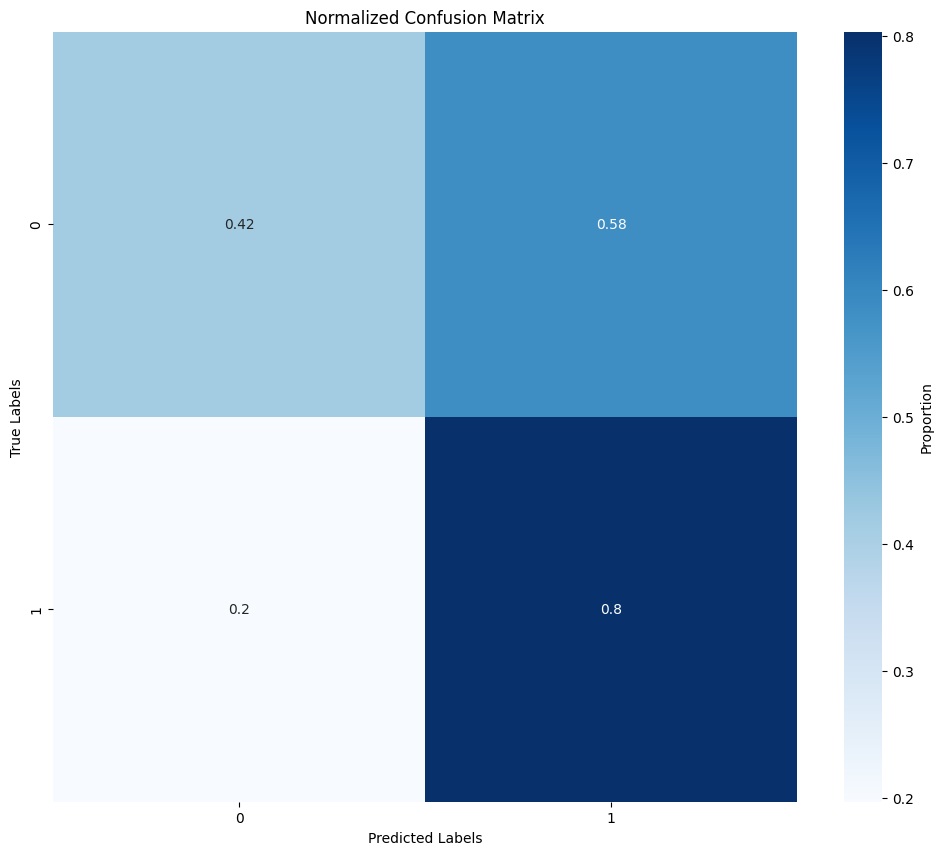

In [101]:
import seaborn as sns
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [102]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the results
print(f'Training Precision: {precision:.4f}')
print(f'Training Recall: {recall:.4f}')
print(f'Training F1-score: {f1:.4f}')

Training Precision: 0.6293
Training Recall: 0.6100
Training F1-score: 0.5948


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


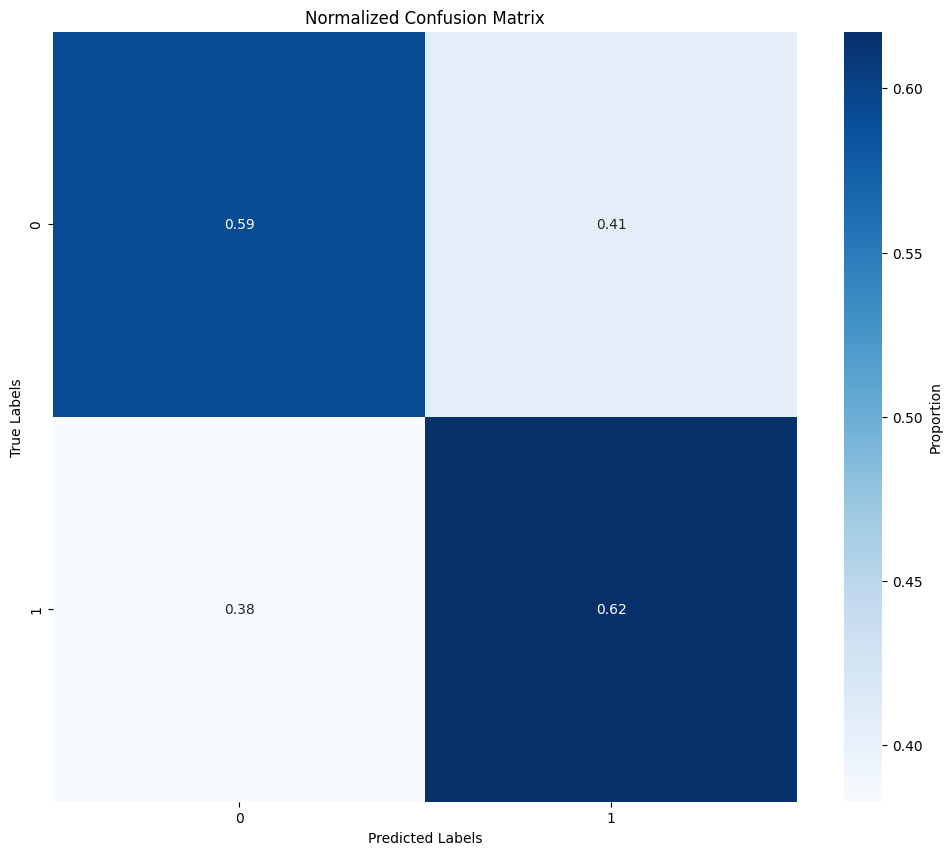

In [103]:
# Initialize lists to store predictions and labels
all_preds = []
all_labels = []

mobilenet_model.eval()  # Set model to evaluation mode

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in validation_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = mobilenet_model(inputs)  # Get model predictions

        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs

        _, predicted = torch.max(logits, 1)  # Get predicted labels
        
        # Append to lists
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the results
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1-score: {f1:.4f}')

Validation Precision: 0.6617
Validation Recall: 0.6006
Validation F1-score: 0.6157


**[4.9]** **Testing:** Now it is time to test our model. Initiate the `model.eval()` along with `torch.no_grad()` to turn off the gradients. Finally calculate the total and correct value.

In [105]:
# Evaluation for test data
mobilenet_model.eval()  # Set model to evaluation mode
test_correct = 0  # Initialize number of correctly predicted samples
test_total = 0  # Initialize total number of samples
test_running_loss = 0.0  # Initialize running test loss

with torch.no_grad():  # Turn off gradients during evaluation
    for inputs, labels in test_loader:  # Iterate through test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = mobilenet_model(inputs)  # Get model predictions
        if isinstance(outputs, tuple):
            logits = outputs[0]  # Unpack logits from model outputs if necessary
        else:
            logits = outputs
        loss = criterion(logits, labels)  # Calculate loss

        test_running_loss += loss.item() * inputs.size(0)  # Update running test loss
        _, predicted = torch.max(logits, 1)  # Get predicted labels
        test_total += labels.size(0)  # Update total number of samples
        test_correct += (predicted == labels).sum().item()  # Update number of correctly predicted samples

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_loader.dataset)  # Average test loss
test_accuracy = test_correct / test_total  # Test accuracy

# Print test results
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test Loss: 0.7231, Test Accuracy: 0.5308


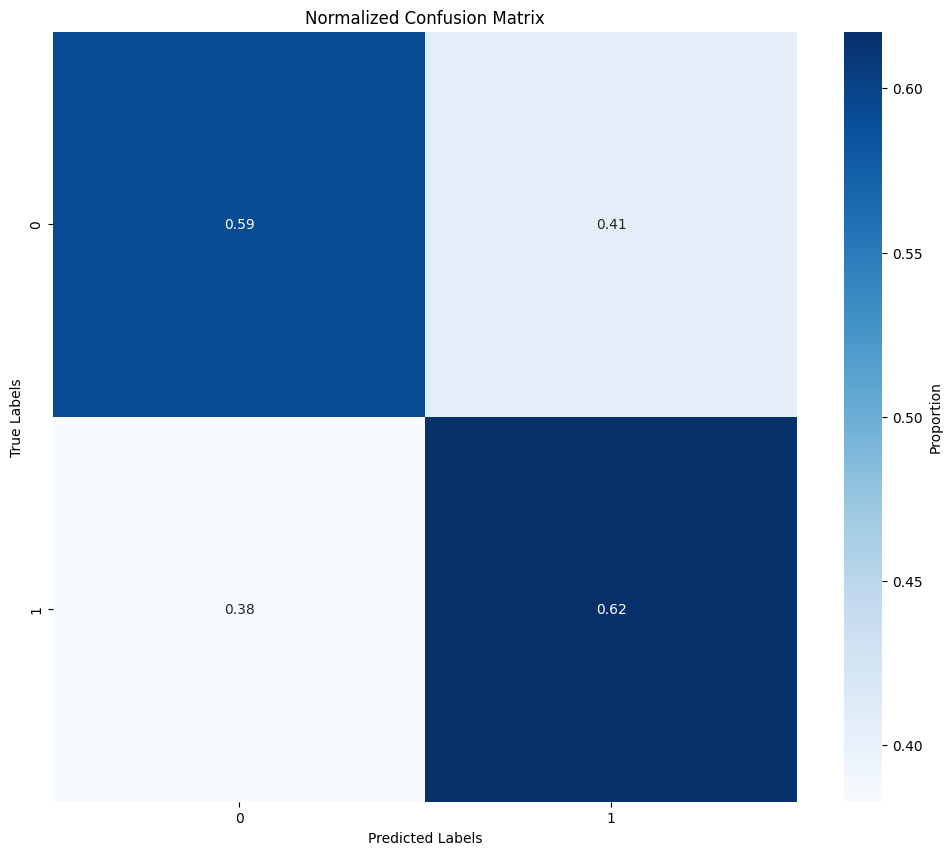

In [106]:
import numpy as np
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [107]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the results
print(f'Testing Precision: {precision:.4f}')
print(f'Testing Recall: {recall:.4f}')
print(f'Testing F1-score: {f1:.4f}')

Testing Precision: 0.6617
Testing Recall: 0.6006
Testing F1-score: 0.6157


### 5. Analysing the Results

**[5.1]** Let's plot the training and validation Accuracies

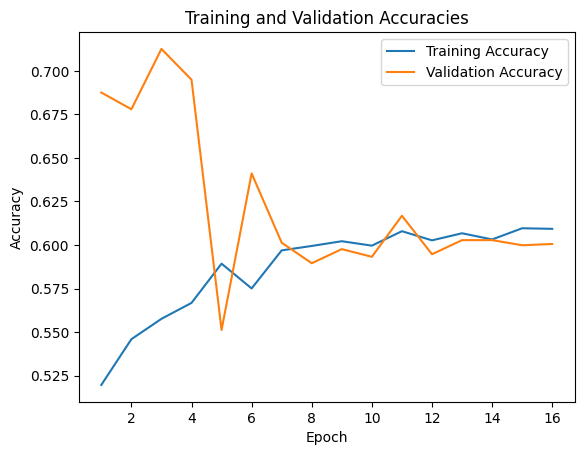

In [108]:
import matplotlib.pyplot as plt

# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation accuracies
plt.plot(epochs, train_accuracies, label='Training Accuracy')  # Plot training accuracies over epochs
plt.plot(epochs, val_accuracies, label='Validation Accuracy')  # Plot validation accuracies over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Accuracy')  # Set label for the y-axis
plt.title('Training and Validation Accuracies')  # Set title for the plot
plt.legend()  # Display legend
plt.show()  # Show the plot

**[5.2]** Let's plot the training and validation losses

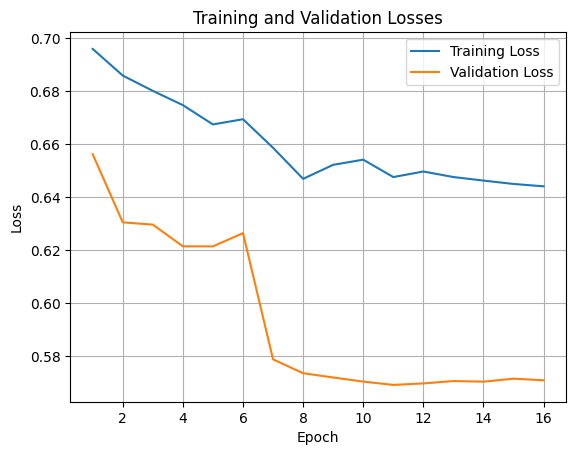

In [109]:
# Plot training and validation losses starting from index 1
epochs = range(1, len(train_losses) + 1)  # Generate the range of epochs starting from 1

# Plot training and validation losses
plt.plot(epochs, train_losses, label='Training Loss')  # Plot training losses over epochs
plt.plot(epochs, val_losses, label='Validation Loss')  # Plot validation losses over epochs
plt.xlabel('Epoch')  # Set label for the x-axis
plt.ylabel('Loss')  # Set label for the y-axis
plt.title('Training and Validation Losses')  # Set title for the plot
plt.legend()  # Display legend
plt.grid(True)  # Display grid
plt.show()  # Show the plot

In [86]:
# Save the entire model
torch.save(mobilenet_model, '/kaggle/working/mobilenet_model_finetunning.pth')
